# Intro to Stock Market Analysis

In this session we will utitlize `Linear Regression` to predict stock market data.

First we would want to complete the colab environment configuration:

In [ ]:
# We import this library to clear the cell output after it's being executed
# Because imstallation will generate lots of logs, clear them will make the
# ...notebook more visible
from IPython.display import clear_output

!pip install --upgrade pandas
!pip install --upgrade pandas_datareader

# We need to install this specific version otherwise graphs won't be displayed
!pip install matplotlib==3.1.3

clear_output(wait=False)

In [ ]:
# Import essential Libraries
# You don't really need to know what these libraries do

import pandas as pd
import datetime
import matplotlib.pyplot as plt
from pylab import rcParams
import numpy as np
import seaborn as sns
import os
import pandas_datareader.data as web
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.feature_selection import RFECV, SelectFromModel, SelectKBest
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
%matplotlib inline

Then we would like to fetch **a fraction of** the `Apple Stock Market Data` from the web using `yahoo` API.

Remember, we need to specify:

1. Begin time of the fraction
2. End time of the fraction
3. Which company's data we want to get
4. Which API we want to use

In [ ]:
# Specify the Start and End time
start_time = datetime.datetime(2018,1,1)
end_time = datetime.datetime(2022,1,1) 

# Specify Company name: Apple (AAPL), API: Yahoo (yahoo)
stock_market_data = web.DataReader("AAPL", 'yahoo', start_time, end_time)

Now we have our data. What about taka a look at it to see what it contains?

Thankfully `Pandas` has provided useful methods for us to peek at the data:

1. using `.head(5)`, we can take a look at **first 5 rows of our data**.
2. using `.tail(5)`, we can take a look at **last 5 rows of our data**.

In [ ]:
# Take a look at the first 5 rows
stock_market_data.head(5)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-01-02,43.075001,42.314999,42.540001,43.064999,102223600.0,41.018429
2018-01-03,43.637501,42.990002,43.132500,43.057499,118071600.0,41.011284
2018-01-04,43.367500,43.020000,43.134998,43.257500,89738400.0,41.201786
2018-01-05,43.842499,43.262501,43.360001,43.750000,94640000.0,41.670872
2018-01-08,43.902500,43.482498,43.587502,43.587502,82271200.0,41.516098


In [ ]:
# Take a look at the last 5 rows
stock_market_data.tail(5)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-12-27,180.419998,177.070007,177.089996,180.330002,74919600.0,179.586868
2021-12-28,181.330002,178.529999,180.160004,179.289993,79144300.0,178.551132
2021-12-29,180.630005,178.139999,179.330002,179.380005,62348900.0,178.640778
2021-12-30,180.570007,178.089996,179.470001,178.199997,59773000.0,177.465637
2021-12-31,179.229996,177.259995,178.089996,177.570007,64062300.0,176.838242


Now we know what kind of entries our data contains, what about **visualize** it? 

Remember, we can use `Matplotlib` to draw `line charts`, which is exactly what we want.

We only care about daily `close` stock price:

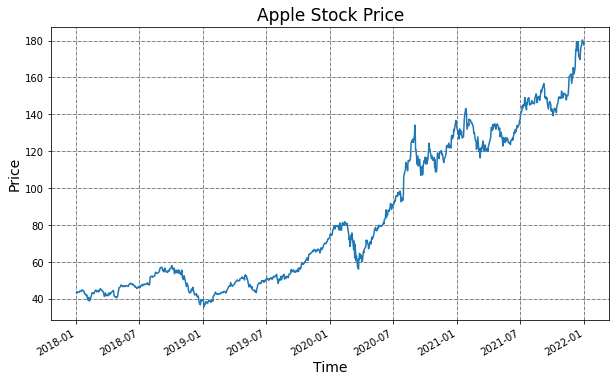

In [ ]:
# Utitlize Matplotlib to draw the line chart of our stock market data

# use the following command to select "Close" column from the entire dataframe:
stock_market_data['Close'].plot(figsize=(10, 6))

# To make the graph clearer we would also want to specify title and the labels of its x and y axes
plt.title("Apple Stock Price", fontsize=17)
plt.ylabel('Price', fontsize=14)
plt.xlabel('Time', fontsize=14)

# Then we will draw the dotted lines to make the graph preetier
plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)

# Finally we plot the graph to make it visible
plt.show()


`Adj_close` is the column that we want to predict here.

In [ ]:
def create_train_test_set(dataframe_stock_market_data):

  features = dataframe_stock_market_data.drop(columns=['Adj Close'], axis=1)
  target = dataframe_stock_market_data['Adj Close']

  data_length = dataframe_stock_market_data.shape[0]

  print("The historical stock market data's length is: ", str(data_length))

  # Then we want to separate the data into three parts: training set, validation set and testing set.
  # We use the conventional train-split ratio: 88% for training, 10% for validation and 2% for testing
  # There's no golden standard for train-test splitting, you can use whatever ratio you want but the performance may not be optimal
  train_split = int(data_length * 0.88)
  print("The training dataset's length is: ", str(train_split))

  val_split = train_split + int(data_length * 0.1)
  print("The validation set's length is: ", str(int(data_length * 0.1)))

  print("The test set's length: ", str(int(data_length * 0.02)))

  # Splitting features and target into train, validation and test samples 
  X_train, X_val, X_test = features[:train_split], features[train_split:val_split], features[val_split:]
  Y_train, Y_val, Y_test = target[:train_split], target[train_split:val_split], target[val_split:]

  #print shape of samples
  print("\nThe shape of samples on x axis (time):")
  print(X_train.shape, X_val.shape, X_test.shape)
  
  print("\nThe shape of samples on y axis (stock price):")
  print(Y_train.shape, Y_val.shape, Y_test.shape)
    
  return X_train, X_val, X_test, Y_train, Y_val, Y_test



In [ ]:
# Generate datasets
X_train, X_validate, X_test, Y_train, Y_validate, Y_test = create_train_test_set(stock_market_data)

The historical stock market data's length is:  1008
The training dataset's length is:  887
The validation set's length is:  100
The test set's length:  20

The shape of samples on x axis (time):
(887, 5) (100, 5) (21, 5)

The shape of samples on y axis (stock price):
(887,) (100,) (21,)


Now we have three small datasets:
1. `Training set`, used to provide information (knowledge) to our model.
2. `Validation set`, used to validate the performance of our model.
3. `Test set`, used to do the actual prediction.

In [ ]:
from sklearn.linear_model import LinearRegression

# Initialize the linear regression model
linear_regression_model = LinearRegression()

# train the model using training set
linear_regression_model.fit(X_train, Y_train)

LinearRegression()

Then we can take a look at the parameters trained from our training set:

In [ ]:
print("Linear Regression Model's Coefficients: \n", linear_regression_model.coef_)
print("Linear Regression Model's Intercept: \n", linear_regression_model.intercept_)

Linear Regression Model's Coefficients: 
 [ 2.57922094e-02  2.45793778e-02 -2.75878327e-02  9.82220424e-01
  9.95220781e-11]
Linear Regression Model's Intercept: 
 -1.8051148449967656


Then we want to perform the model evaluation on our validation set:

In [ ]:
print("The Performance of our model (R^2): ", linear_regression_model.score(X_train, Y_train))

The Performance of our model (R^2):  0.9999254833001847


In [ ]:
def get_mape(y_truth, y_predicted): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_truth, y_predicted = np.array(y_truth), np.array(y_predicted)
    return np.mean(np.abs((y_truth - y_predicted) / y_truth)) * 100

Finally we will perform the prediction for the test dataset:

In [ ]:
# Get predicted data for training set, validation set and test set.
Y_train_predicted = linear_regression_model.predict(X_train)
Y_validate_predicted = linear_regression_model.predict(X_validate)
Y_test_predicted = linear_regression_model.predict(X_test)

# print out prediction result of these three datasets respectively
print("Training R-squared: ",round(metrics.r2_score(Y_train,Y_train_predicted),2))
print("Training Explained Variation: ",round(metrics.explained_variance_score(Y_train,Y_train_predicted),2))
print('Training MAPE:', round(get_mape(Y_train,Y_train_predicted), 2)) 
print('Training Mean Squared Error:', round(metrics.mean_squared_error(Y_train,Y_train_predicted), 2)) 
print("Training RMSE: ",round(np.sqrt(metrics.mean_squared_error(Y_train,Y_train_predicted)),2))
print("Training MAE: ",round(metrics.mean_absolute_error(Y_train,Y_train_predicted),2))

print(' ')

print("Validation R-squared: ",round(metrics.r2_score(Y_validate,Y_validate_predicted),2))
print("Validation Explained Variation: ",round(metrics.explained_variance_score(Y_validate,Y_validate_predicted),2))
print('Validation MAPE:', round(get_mape(Y_validate,Y_validate_predicted), 2)) 
print('Validation Mean Squared Error:', round(metrics.mean_squared_error(Y_train,Y_train_predicted), 2)) 
print("Validation RMSE: ",round(np.sqrt(metrics.mean_squared_error(Y_validate,Y_validate_predicted)),2))
print("Validation MAE: ",round(metrics.mean_absolute_error(Y_validate,Y_validate_predicted),2))

print(' ')

print("Test R-squared: ",round(metrics.r2_score(Y_test,Y_test_predicted),2))
print("Test Explained Variation: ",round(metrics.explained_variance_score(Y_test,Y_test_predicted),2))
print('Test MAPE:', round(get_mape(Y_test,Y_test_predicted), 2)) 
print('Test Mean Squared Error:', round(metrics.mean_squared_error(Y_test,Y_test_predicted), 2)) 
print("Test RMSE: ",round(np.sqrt(metrics.mean_squared_error(Y_test,Y_test_predicted)),2))
print("Test MAE: ",round(metrics.mean_absolute_error(Y_test,Y_test_predicted),2))

Training R-squared:  1.0
Training Explained Variation:  1.0
Training MAPE: 0.45
Training Mean Squared Error: 0.08
Training RMSE:  0.29
Training MAE:  0.25
 
Validation R-squared:  1.0
Validation Explained Variation:  1.0
Validation MAPE: 0.15
Validation Mean Squared Error: 0.08
Validation RMSE:  0.25
Validation MAE:  0.22
 
Test R-squared:  1.0
Test Explained Variation:  1.0
Test MAPE: 0.12
Test Mean Squared Error: 0.04
Test RMSE:  0.21
Test MAE:  0.2


Then we will wrap up our prediction data as several `pandas dataframes`:

In [ ]:
dataframe_predicted = pd.DataFrame(Y_validate.values, columns=['Actual'], index = Y_validate.index)
dataframe_predicted['Predicted'] = Y_validate_predicted

dataframe_predicted = dataframe_predicted.reset_index()
dataframe_predicted.loc[:, 'Date'] = pd.to_datetime(dataframe_predicted['Date'], format='%Y-%m-%d')
dataframe_predicted.head(5)


,Date,Actual,Predicted
0,2021-07-13,144.611801,144.615682
1,2021-07-14,148.096985,148.107565
2,2021-07-15,147.431732,147.412604
3,2021-07-16,145.356491,145.344004
4,2021-07-19,141.444305,141.356560


Last but not least, we will plot the price we predicted together with the actual price on the same plot.

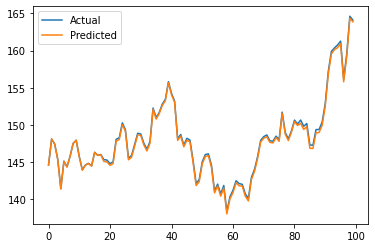

In [ ]:
dataframe_predicted[['Actual', 'Predicted']].plot()

We can see that overall the prediction looks very good comparing to the actual data!